In [2]:
import numpy as np
import fabio
#import cupy as cp
from datetime import datetime
from numba import jit, cuda, prange

In [3]:
#initialze detector info
# //These are the details of the detector in the detInfo wave
# 	//detInfo[0] = xdim
# 	//detInfo[1] = ydim
# 	//detInfo[2] = xpixsize	Given in mm
# 	//detInfo[3] = ypixsize	Given in mm
# 	//detInfo[4] = xcen (pixels)
# 	//detInfo[5] = ycen (pixels)
# 	//detInfo[6] = tiltang	Given in degrees
# 	//detInfo[7] = tiltrot		Given in degrees
# 	//detInfo[8] = sample to detector distance	Given in mm
# 	//detInfo[9] = lamda	Given in Angstroms
# detInfo = np.array([1475,1679,0.17200001,0.17200001,738.00598,829.4032,0,0,450,0.23946001])
detInfo = np.array([2048,2048,0.17200001,0.17200001,738.00598,829.4032,0,0,450,0.23946001])
imFilePrefix = ""
imNumbers = np.arange(1,1000)
boxsize = 801
qmax = 4
# boxname = ""
omegaPos = np.arange(0,180,0.2)
phiPos = np.zeros(180)
psiPos = np.zeros(180)
# phiPos = np.arange(0,0,0.2)
# psiPos = np.arange(0,0,0.2)
mask = []
rejects = []
cust_mask = []
mask_list = []
rotmatrix = np.eye(3)
normInt = np.arange(1,1000)
startIm = 30
# box = np.zeros((boxsize,boxsize,boxsize),dtype=np.float32)

In [9]:
def DiffuseReconstruction_cupy(fileNum):
    
    mempool = cp.get_default_memory_pool()
    tiltang = detInfo[6]*cp.pi/180 
    tiltrot = detInfo[7]*cp.pi/180 
    dist = detInfo[8]

#     row,col = cp.indices((int(detInfo[0]),int(detInfo[1])))
    row = cp.arange(0,int(detInfo[0])).repeat(int(detInfo[1])).reshape(int(detInfo[0]),int(detInfo[1]))
    col = cp.arange(0,int(detInfo[1])).repeat(int(detInfo[0])).reshape(int(detInfo[1]),int(detInfo[0]))
    col = cp.transpose(col)
    TT = (cp.arctan(cp.sqrt((cp.cos(tiltang)**2*(cp.cos(tiltrot)*((row-detInfo[4])*detInfo[2])+cp.sin(tiltrot)*((col-detInfo[5])*detInfo[3]))**2 + (-cp.sin(tiltrot)*((row-detInfo[4])*detInfo[2]) + cp.cos(tiltrot)*((col-detInfo[5])*detInfo[3]))**2)/((dist+cp.sin(tiltang)*(cp.cos(tiltrot)*((row-detInfo[4])*detInfo[2])+cp.sin(tiltrot)*((col-detInfo[5])*detInfo[3])))**2))))/2
    AZ = cp.arctan2(((col-detInfo[5])*detInfo[3]), ((row-detInfo[4])*detInfo[2]))+cp.pi
#     grid = cp.indices((int(detInfo[0]),int(detInfo[1])))
#     TT = (cp.arctan(cp.sqrt((cp.cos(tiltang)**2*(cp.cos(tiltrot)*((grid[0]-detInfo[4])*detInfo[2])+cp.sin(tiltrot)*((grid[1]-detInfo[5])*detInfo[3]))**2 + (-cp.sin(tiltrot)*((grid[0]-detInfo[4])*detInfo[2]) + cp.cos(tiltrot)*((grid[1]-detInfo[5])*detInfo[3]))**2)/((dist+cp.sin(tiltang)*(cp.cos(tiltrot)*((grid[0]-detInfo[4])*detInfo[2])+cp.sin(tiltrot)*((grid[1]-detInfo[5])*detInfo[3])))**2))))/2
#     AZ = cp.arctan2(((grid[1]-detInfo[5])*detInfo[3]), ((grid[0]-detInfo[4])*detInfo[2]))+cp.pi

    TT1D = cp.reshape(TT,int(detInfo[0])*int(detInfo[1]))
    AZ1D = cp.reshape(AZ,int(detInfo[0])*int(detInfo[1]))

    # boxname = cp.empty((boxsize,boxsize,boxsize))
    # boxname[:] = cp.NaN
    # numpixels = cp.empty((boxsize,boxsize,boxsize))
    # numpixels[:] = cp.NaN

    box = cp.zeros((boxsize,boxsize,boxsize),dtype=cp.float32)
    numpixels = cp.zeros((boxsize,boxsize,boxsize),dtype=int)
    # Use ravel() for shallow copy or flatten() for deep copy

#     omega = 0
#     phi = 0
#     psi = 0
#     qx = cp.zeros(int(detInfo[0])*int(detInfo[1]))
#     qy = cp.zeros(int(detInfo[0])*int(detInfo[1]))
#     qz = cp.zeros(int(detInfo[0])*int(detInfo[1]))
#     BBposX = cp.zeros(int(detInfo[0])*int(detInfo[1]))
#     BBposY = cp.zeros(int(detInfo[0])*int(detInfo[1]))
#     BBposZ = cp.zeros(int(detInfo[0])*int(detInfo[1]))

    qrangex = cp.linspace(-(qmax),qmax,boxsize)
    qrangey = cp.linspace(-(qmax),qmax,boxsize)
    qrangez = cp.linspace(-(qmax),qmax,boxsize)
    
    
#     mempool.free_all_blocks()

    # for i in range(int(detInfo[0])*int(detInfo[1])):
    for i in range(fileNum):
        omega = omegaPos[i]*cp.pi/180
        phi = phiPos[i]*cp.pi/180
        psi = psiPos[i]*cp.pi/180

        qx = (4*cp.pi*cp.sin(TT1D)/detInfo[9]) * (cp.sin(TT1D)*(cp.sin(phi)*cp.sin(psi)*cp.sin(omega) + cp.cos(phi)*cp.cos(omega)) + cp.cos(TT1D)*cp.cos(AZ1D)*cp.sin(phi)*cp.cos(psi) - cp.cos(TT1D)*cp.sin(AZ1D)*(cp.sin(phi)*cp.sin(psi)*cp.cos(omega) - cp.cos(phi)*cp.sin(omega)))
        qy = (4*cp.pi*cp.sin(TT1D)/detInfo[9]) * (-cp.sin(TT1D)*(cp.cos(phi)*cp.sin(psi)*cp.sin(omega) - cp.sin(phi)*cp.cos(omega)) - cp.cos(TT1D)*cp.cos(AZ1D)*cp.cos(phi)*cp.cos(psi) + cp.cos(TT1D)*cp.sin(AZ1D)*(cp.cos(phi)*cp.sin(psi)*cp.cos(omega) + cp.sin(phi)*cp.sin(omega)))
        qz = (4*cp.pi*cp.sin(TT1D)/detInfo[9]) * (cp.sin(TT1D)*cp.cos(psi)*cp.sin(omega) - cp.cos(TT1D)*cp.sin(AZ1D)*cp.cos(psi)*cp.cos(omega) - cp.cos(TT1D)*cp.cos(AZ1D)*cp.sin(psi))

        BBposX = cp.round((qx - (qmax)) / (qrangex[1]-qrangex[0]))
        BBposY = cp.round((qy - (qmax)) / (qrangey[1]-qrangey[0]))
        BBposZ = cp.round((qz - (qmax)) / (qrangez[1]-qrangez[0]))

    

In [4]:

# @jit(nopython=True,parallel=True)
def DiffuseReconstruction(fileNum):
    tiltang = detInfo[6]*np.pi/180 
    tiltrot = detInfo[7]*np.pi/180 
    dist = detInfo[8]

#     row,col = np.indices((int(detInfo[0]),int(detInfo[1])))
    row = np.arange(0,int(detInfo[0])).repeat(int(detInfo[1])).reshape(int(detInfo[0]),int(detInfo[1]))
    col = np.arange(0,int(detInfo[1])).repeat(int(detInfo[0])).reshape(int(detInfo[1]),int(detInfo[0]))
    col = np.transpose(col)
    TT = (np.arctan(np.sqrt((np.cos(tiltang)**2*(np.cos(tiltrot)*((row-detInfo[4])*detInfo[2])+np.sin(tiltrot)*((col-detInfo[5])*detInfo[3]))**2 + (-np.sin(tiltrot)*((row-detInfo[4])*detInfo[2]) + np.cos(tiltrot)*((col-detInfo[5])*detInfo[3]))**2)/((dist+np.sin(tiltang)*(np.cos(tiltrot)*((row-detInfo[4])*detInfo[2])+np.sin(tiltrot)*((col-detInfo[5])*detInfo[3])))**2))))/2
    AZ = np.arctan2(((col-detInfo[5])*detInfo[3]), ((row-detInfo[4])*detInfo[2]))+np.pi
#     grid = np.indices((int(detInfo[0]),int(detInfo[1])))
#     TT = (np.arctan(np.sqrt((np.cos(tiltang)**2*(np.cos(tiltrot)*((grid[0]-detInfo[4])*detInfo[2])+np.sin(tiltrot)*((grid[1]-detInfo[5])*detInfo[3]))**2 + (-np.sin(tiltrot)*((grid[0]-detInfo[4])*detInfo[2]) + np.cos(tiltrot)*((grid[1]-detInfo[5])*detInfo[3]))**2)/((dist+np.sin(tiltang)*(np.cos(tiltrot)*((grid[0]-detInfo[4])*detInfo[2])+np.sin(tiltrot)*((grid[1]-detInfo[5])*detInfo[3])))**2))))/2
#     AZ = np.arctan2(((grid[1]-detInfo[5])*detInfo[3]), ((grid[0]-detInfo[4])*detInfo[2]))+np.pi

    TT1D = np.reshape(TT,int(detInfo[0])*int(detInfo[1]))
    AZ1D = np.reshape(AZ,int(detInfo[0])*int(detInfo[1]))

#     boxname = np.empty((boxsize,boxsize,boxsize))
#     boxname[:] = np.NaN
#     numpixels = np.empty((boxsize,boxsize,boxsize))
#     numpixels[:] = np.NaN
#     boxname = np.zeros((boxsize,boxsize,boxsize))
#     numpixels = np.zeros((boxsize,boxsize,boxsize))

    boxname = np.zeros((boxsize,boxsize,boxsize),dtype=np.float32)
    num = np.zeros((boxsize,boxsize,boxsize),dtype=np.int_)
    # Use ravel() for shallow copy or flatten() for deep copy

#     omega = 0
#     phi = 0
#     psi = 0
#     qx = np.zeros(int(detInfo[0])*int(detInfo[1]))
#     qy = np.zeros(int(detInfo[0])*int(detInfo[1]))
#     qz = np.zeros(int(detInfo[0])*int(detInfo[1]))
    BBposX = np.zeros(int(detInfo[0])*int(detInfo[1]),dtype=np.int_)
    BBposY = np.zeros(int(detInfo[0])*int(detInfo[1]),dtype=np.int_)
    BBposZ = np.zeros(int(detInfo[0])*int(detInfo[1]),dtype=np.int_)

    qrangex = np.linspace(-(qmax),qmax,boxsize)
    qrangey = np.linspace(-(qmax),qmax,boxsize)
    qrangez = np.linspace(-(qmax),qmax,boxsize)

    # for i in range(int(detInfo[0])*int(detInfo[1])):
    for i in range(fileNum):
        if i % 10 == 0:
            print(i)
        #use FABIO to load the image
#         CI_fabio = fabio.open("E:\\ESRF_Oct_2014_Experiments\\Debbie_Single_Crystal_experiments\\s1_363K_2p0_diffuse\\DisCorr\\s1_363K_2p0_diffuse_0000.edf")
#         CI_fabio = fabio.open("C:\\Users\\Patrick\\Desktop\\s1_363K_2p0_diffuse\\DisCorr\\s1_363K_2p0_diffuse_0000.edf")
        CI_fabio = fabio.open("C:\\Users\\Patrick\\Desktop\\s1_363K_2p0_diffuse\\DisCorr\\s1_363K_2p0_diffuse_"+("%04d" % (i))+".edf")
        #convert to numpy array
        CI = np.asarray(CI_fabio.data)
        CI = np.reshape(CI,int(detInfo[0])*int(detInfo[1]))
        (bigbox,numpixels) = looper(i,CI,TT1D,AZ1D,qmax,qrangex,qrangey,qrangez,BBposX,BBposY,BBposZ,boxname,num)
        boxname += bigbox
        num += numpixels
#     print(boxname)
    np.seterr(divide='ignore', invalid='ignore')
    boxname = boxname/num
    
    return boxname
    
#     print(boxname[17, 656, 549])

In [5]:
@jit(nopython=True,parallel=True)
def looper(row,image,TT1D,AZ1D,qmax,qrangex,qrangey,qrangez,BBposX,BBposY,BBposZ,bigbox,numpixels):
    
#     bigbox = np.zeros((boxsize,boxsize,boxsize),dtype=np.float32)
#     numpixels = np.zeros((boxsize,boxsize,boxsize),dtype=np.int_)
    
    omega = omegaPos[row]*np.pi/180
    phi = phiPos[row]*np.pi/180
    psi = psiPos[row]*np.pi/180

    qx = (4*np.pi*np.sin(TT1D)/detInfo[9]) * (np.sin(TT1D)*(np.sin(phi)*np.sin(psi)*np.sin(omega) + np.cos(phi)*np.cos(omega)) + np.cos(TT1D)*np.cos(AZ1D)*np.sin(phi)*np.cos(psi) - np.cos(TT1D)*np.sin(AZ1D)*(np.sin(phi)*np.sin(psi)*np.cos(omega) - np.cos(phi)*np.sin(omega)))
    qy = (4*np.pi*np.sin(TT1D)/detInfo[9]) * (-np.sin(TT1D)*(np.cos(phi)*np.sin(psi)*np.sin(omega) - np.sin(phi)*np.cos(omega)) - np.cos(TT1D)*np.cos(AZ1D)*np.cos(phi)*np.cos(psi) + np.cos(TT1D)*np.sin(AZ1D)*(np.cos(phi)*np.sin(psi)*np.cos(omega) + np.sin(phi)*np.sin(omega)))
    qz = (4*np.pi*np.sin(TT1D)/detInfo[9]) * (np.sin(TT1D)*np.cos(psi)*np.sin(omega) - np.cos(TT1D)*np.sin(AZ1D)*np.cos(psi)*np.cos(omega) - np.cos(TT1D)*np.cos(AZ1D)*np.sin(psi))

    np.round((qx - (qmax)) / (qrangex[1]-qrangex[0]),0,BBposX)
    np.round((qy - (qmax)) / (qrangey[1]-qrangey[0]),0,BBposY)
    np.round((qz - (qmax)) / (qrangez[1]-qrangez[0]),0,BBposZ)
#     print(BBposX)
#     print(BBposY)
#     print(BBposZ)
#         BBposX = np.round((qx - (qmax)) / (qrangex[1]-qrangex[0]))
#         BBposY = np.round((qy - (qmax)) / (qrangey[1]-qrangey[0]))
#         BBposZ = np.round((qz - (qmax)) / (qrangez[1]-qrangez[0]))

    for j in range(image.size):
        
        if(0 <= BBposX[j] and 0 <= BBposY[j] and 0 <= BBposZ[j] and BBposX[j] < bigbox.shape[0] and BBposY[j] < bigbox.shape[1] and BBposZ[j] < bigbox.shape[2] ):
            if(np.isfinite(image[j])):
                
#             print(j)
#                 if(np.isnan(boxname[BBposX[j],BBposY[j],BBposZ[j]]) == True):
                bigbox[BBposX[j],BBposY[j],BBposZ[j]] += image[j]
                numpixels[BBposX[j],BBposY[j],BBposZ[j]] += 1 
#             print(BBposX[j],BBposY[j],BBposZ[j])
#         print(image[j])
#     print(boxname[17, 656, 549])
#     print(numpixels[17, 656, 549])
#     box = boxname/numpixels
#     return box[400,400,400]
    return bigbox,numpixels

In [39]:
box = DiffuseReconstruction(10)

0


C:\Users\Patrick\anaconda3\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\Patrick\anaconda3\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\Patrick\anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Patrick\anaconda3\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\Patrick\anaconda3\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


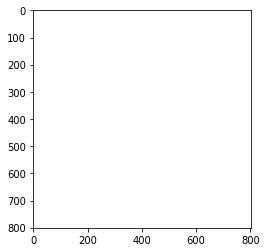

In [7]:
from matplotlib import pyplot       # Load matplotlib
pyplot.imshow(box[:, :, 549]) 
pyplot.show() 


In [7]:
import winsound
winsound.Beep(300, 750)

In [37]:
box[:, :, 549]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [6]:
startTime = datetime.now()

box = DiffuseReconstruction(100)

print(datetime.now() - startTime)

0
10
20
30
40
50
60
70
80
90
0:01:24.638224
